In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.fft as fft
import scipy.interpolate as interpolate

## FFT - Fast Fourier Transformation

$$f(x) = \frac{1}{2\pi} \int_{ - \infty}^{+ \infty} e^{-izx} \phi (z)dz$$
if we want to calculate the density for many $x$ we need to compute an integral, this can be very computational expensive if we need it for many $x$.
Let us formulate the pricing problem:
$$ \mathbb{E}\bigg(\frac{V(T)}{M(T)}\bigg) = \int_{\mathbb{R}} e^{-rT} \cdot \Pi(T) \cdot f_X(x) dx$$
In this case we need to discretize the integral and for each $X$ in our domain we need to evaluate  the intefral above.
FFT can help to get a much more faster implementation.


## Inversion Lemma

Let $\phi(z)$ be a characteristic function and $f(x)$ be a probability density function of some continuos variable X. Then we have:
$$ f(x) = \frac{1}{\pi} \mathcal{R}\bigg(\int_0^{ + \infty} e^{-izx} \phi(z) dz\bigg)$$

## Proof:
from Fourier Inverse:
$$ f(x) = \frac{1}{2\pi} \int_{ - \infty}^{+ \infty} e^{-izx} \phi (z)dz$$
$$f(x) = \frac{1}{2\pi}\bigg(  \int_{ - \infty}^{0} e^{-izx} \phi (z)dz +  \int_{0}^{ \infty} e^{-izx} \phi (z)dz\bigg) $$


where the first integral on the RHS can be written as:
$$\int_{ - \infty}^{0} e^{-izx} \phi (z)dz = \int_{0}^{\infty} e^{ivx} \phi (-v)dv$$
By taking the conjugate of the first integral and using the fact that the conjugate of an exponent equals the exponent of the conjugate, we find:
$$ \int_{0}^{\infty} e^{ivx} \phi (-v)dv = \int_{0}^{\infty} \overline{e^{-izx} \phi (z)}dz = \overline{\int_{0}^{\infty} {e^{-izx} \phi (z)}dz } $$

using the property of complex numbers $ z +\overline{z}=2 \mathcal{R}(z)$ therefore the density can be expressed as:
$$ f(x) = \frac{1}{\pi} \mathcal{R}\bigg(\int_0^{\infty} e^{-izx}\phi(z) dz \bigg) $$

$$f(x) = \frac{1}{2\pi}\bigg( \overline{\int_{0}^{\infty} {e^{-izx} \phi (z)}dz } +  \int_{0}^{ \infty} e^{-izx} \phi (z)dz\bigg) $$ 
$$ f(x) = \frac{1}{\pi} \mathcal{R}\bigg(\int_0^{\infty} e^{-izx}\phi(z) dz \bigg) $$


Given that we discretize the domain for \( x \) and \( z \) into \( N \) grid points, we consider the vectors $f, \phi \in \mathbb{C}^N $:
$$
f = \begin{pmatrix}
f_1 \\
f_2 \\
\vdots \\
f_{N-1} \\
f_N 
\end{pmatrix}
$$

$$
\phi = \begin{pmatrix}
\phi_1 \\
\phi_2 \\
\vdots \\
\phi_{N-1} \\
\phi_N 
\end{pmatrix}
$$

Let us consider the following representation:
$$ \int_0^{\infty} e^{-izx}\phi(z)dz \coloneqq \ \int_0^{\infty} \gamma(z)dz $$

We define  a trapezoidal integration over domain $[0, z_{max}]$ for which we have:
$$ \int_0^{z_{max}} \gamma(z)d(z) \approx \frac{\Delta_z}{2}\bigg[\gamma(z_1) + 2 \sum_{2}^{N-1} \gamma(z_n) + \gamma{z_N}\bigg]$$


$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=2}^{N-1} \gamma(z_n) + \frac{1}{2} \gamma(z_1) + \frac{1}{2} \gamma(z_N) \right]
$$


- $z_{max} = N\Delta_z$
- $z_n = (z-1)\Delta_z$
- $x_k= x_{min} + \Delta_x(k-1)$

$x_min=b$ is a tuning parameter which can be freely chosen, typically it should be associated with a low quantile of distribution such that $P[X<b]< \epsilon $

we have to specify $\Delta_z$ interval, the number of points and the $x_{min}$

$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=1}^{N} e^{-i[(n-1)\Delta_z][+x_{min} + \Delta_x(k-1)]} \phi(z_n)  - \frac{1}{2}\bigg[e^{-ixz_1} \phi(z_1) + e^{ixz_N}\phi(z_N)\bigg]\right]
$$
$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=1}^{N} e^{-i\Delta_x\Delta_z(n-1)(k-1)}e^{-i(n-1)x_{min}\Delta_z} \phi(z_n)  - \frac{1}{2}\bigg[e^{-ixz_1} \phi(z_1) + e^{-ixz_N}\phi(z_N)\bigg]\right]
$$


if we set:
$$ \Delta_x\Delta_z = \frac{2\pi}{N}$$
and since $z= (n-1)\Delta_z$
we obtain:
$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=1}^{N} e^{-i\frac{2\pi}{N}(n-1)(k-1)}e^{-ix_{min}z} \phi(z_n)  - \frac{1}{2}\bigg[e^{-ixz_1} \phi(z_1) + e^{-ixz_N}\phi(z_N)\bigg]\right]
$$

so finally we obtain:
$$ f(x) = \frac{1}{\pi} \mathcal{R} \bigg(\int_0^{\infty} e^{-izx}\phi(z)dz\bigg) = \frac{\Delta_z}{\pi} \mathcal{R}\left( \left[ \sum_{n=1}^{N} e^{-i\frac{2\pi}{N}(n-1)(k-1)}e^{-ix_{min}z} \phi(z_n)  - \frac{1}{2}(\gamma_1 + \gamma_2)\right] \right)$$

where $\gamma_1=e^{-ixz_1} \phi(z_1)$ and $\gamma_2 = e^{-ixz_N}\phi(z_N)$

In the following representation we have a considered a fixed grid for x_k, howeveris not ensured that x in $f(x)$ is a point in the grid. For that reason, typically an interpolation between grid of points of $x_k$ is considered.

It is necessary to perform a matrix multiplication which requires around $N^2$ (complex) mulitplications and $N^2$ additions, the number of arithmetic operations is of order $N^2$ $\mathcal{O}(N^2)$
- It is possible to have Discretized fourier transform (DFT) evaluated in $\mathcal{O}(N log_2 N)$ operations.
- The algorithm was called FFT, available in many computer languages

Again we discretize the domain for x, and z into N grid points and we consider the vectors $f,\phi \in \mathbb{C}^N$
$$
f = \begin{pmatrix}
f_1 \\
f_2 \\
\vdots \\
f_{N-1} \\
f_N 
\end{pmatrix}
$$

$$
\phi = \begin{pmatrix}
\phi_1 \\
\phi_2 \\
\vdots \\
\phi_{N-1} \\
\phi_N 
\end{pmatrix}
$$

the discrete Fourier transform $f$ of $phi$ is given by the matrix multiplication:
$$ f = M\phi$$
or equivalently:
$$f_k= \sum_{n=1}^{N} \phi_n e^{-i\frac{2\pi}{N}(n-1)(k-1)}=\sum_{n=1}^{N} \phi_n \bar{w}_N^{(n-1)(k-1)} $$

the discretized Fourier Transform matrix $M \in \mathbb{C}^{N \times N}$ is then defined as:
$$
M= \begin{pmatrix}
1 & 1 & 1 & ...& 1 \\
1 & \bar{w}_N^1 & \bar{w}_N^2 & ... &  \bar{w}_N^{N-1}  \\
1 & \bar{w}_N^2 & \bar{w}_N^4 & ... &  \bar{w}_N^{2(N-1)} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \bar{w}_N^{N-1} & \bar{w}_N^{N(N-1)} & ... &  \bar{w}_N^{(N-1)(N-1)} \\
\end{pmatrix}
$$


$$M_{n,k}= \bar{w}_N^{(n-1)(k-1)}

with $N=2^L$(even). <br>
Define $x_n = \phi_{2_{n-1}}$ and $y_n$ $y_n = \phi_2{n}$ for $n=1, ..., N/2$ $(x_n , y_n)$ are the odd and even sequences of $\phi_n$

$$f_k= \sum_{n=1}^{N/2}x_n \bar{w}_N^{(2n-2)(k-1)} + y_n \bar{w}_N^{(2n-1)(k-1)}$$
for $k=1, ..., N$

 $$

the basis behind the FFT is the simple but crucial equality:
$$\bar{w}_N^{(2_n-2)(k-1)} = \bar{w}_{N/2}^{(n-1)(k-1)}$$

$$f_k= \sum_{n=1}^{N/2}x_n \bar{w}_{N/2}^{(n-1)(k-1)} + \bar{w}_{N}^{(k-1)} \sum_{n=1}^{N/2} y_n \bar{w}^{(2n-1)(k-1)}= Z_k + \bar{w}_{N}^{(k-1)} Y_k $$
which is apart from a facotr $ \bar{w}_{N}^{(k-1)}$ the sum of two DFTs, each of length $N/2$. <br> 
Hence we can write:
$$ f_k = Z_k + \bar{w}_N^{k-1}Y_k$$
$$ f_{k+ N/2} = Z_{k + N/2} +\bar{w}_{N}^{(k-1) + N/2} Y_{k + N/2}$$
for $k=1, ..., N/2$

Taking the characteristic function for a normal random varialble $\mathcal{N}(\mu,\sigma^2)$:
$$\phi_X(\mu) = e^{i\mu z - \frac{1}{2}\sigma^2z^2} $$
can be interesting comparing the original pdf with the FFT approximation.

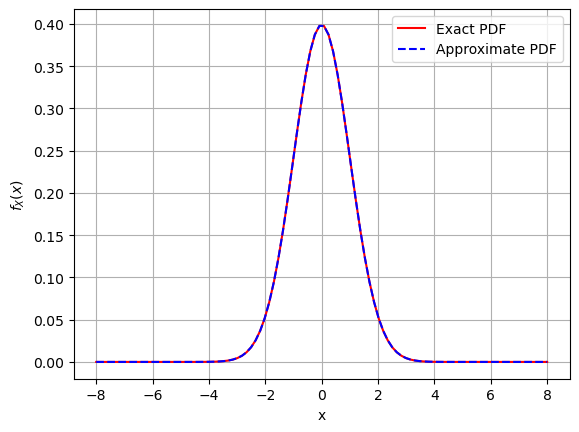

In [10]:
def RecoverDensity(cf, x, N=8192):
    i = complex(0.0, 1.0)  # assigning i=sqrt(-1)

    # specification of the grid for u
    u_max = 20.0
    du = u_max / N
    u = np.linspace(0, N-1, N) * du

    # grid for x
    b = np.min(x)
    dx = 2.0 * np.pi / (N * du)
    x_i = b + np.linspace(0, N-1, N) * dx

    phi = np.exp(-i * b * u) * cf(u)

    gamma_1 = np.exp(-i * x_i * u[0]) * cf(u[0])
    gamma_2 = np.exp(-i * x_i * u[-1]) * cf(u[-1])

    phi_boundary = 0.5 * (gamma_1 + gamma_2)

    f_xi = du / np.pi * np.real(fft.fft(phi) - phi_boundary)

    f_xiInterp = interpolate.interp1d(x_i, f_xi, kind='cubic')

    return f_xiInterp(x)

def mainCalculation():
    i = complex(0.0, 1.0)  # assigning i=sqrt(-1)

    # setting for normal distribution
    mu = 0.0
    sigma = 1.0

    # Define characteristic function for the normal distribution
    cF = lambda u: np.exp(i * mu * u - 0.5 * sigma**2.0 * u**2.0)

    # define domain for density
    x = np.linspace(-8.0, 8.0, 100)
    f_XExact = st.norm.pdf(x, mu, sigma)

    # recovered density
    f_XR = RecoverDensity(cF, x)

    plt.figure(1)
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("$f_X(x)$")
    plt.plot(x, f_XExact, '-r', label="Exact PDF")
    plt.plot(x, f_XR, '--b', label="Approximate PDF")
    plt.legend()
    plt.show()

mainCalculation()

## Fourier-Cosine Expansion (COS method)
- Exponential convergence,
- Greeks are obtained at no additional cost <br>
The basic idea is to replace the density by its Fourier-cosine series expansion. <br>
The density and its characteristic function, $f_X(y) \text{and} \phi_X(z)$ form a Fourier pair,
- $\phi_X(z)= \int_{\mathbb{R}}e^{iyz}f_X(y) dy$ <br>
- $f_X(y)= \frac{1}{2\pi} \int_{\mathbb{R}}e^{-iyz} \phi_X(z) dz$

 Fourier cosine series expansions give an optimal approximation of functions with a finite support.
 Definition of the Fourier expansion of a function $g(x)$ on $[-1,1]$:
 $$ g(\theta) = \sum_{k=0}^{'\infty} \bar{A}_k cos(k\pi\theta) + \sum_{k=1}^{\infty} \bar{B}_k sin(k\pi\theta) $$
 where the $'$ at the first sum, indicates that the first term in the sum is weighted by one half, and the coefficients are given by:
 - $\bar{A}_k = \int_{-1}^{1}g(\theta) cos(k\pi\theta)d\theta$,
 - $\bar{B}_k = \int_{-1}^{1}g(\theta) sin(k\pi\theta)d\theta$

By setting $\bar{B}_k=0$ we obtain the classical Fourier Cosine expansion, by which we can represent even functions around $\theta=0$ exactly.
We can extend any function $g: [0,\pi] \Rightarrow \mathbb{R}$ to become an even function on $[-\pi,\pi] as follows,
$$ \bar{g}(\theta)=\begin{cases} g(\theta), \theta > 0 \\
                            g(-\theta), \theta < 0 \end{cases}$$

Even functions can be expressed as Fourier Cosine series.

For a function \bar{\theta}:
$$ \bar{g}(\theta) = \sum_{k=0}^{'\infty} \bar{A}_k cos(k\theta) $$

with: 
- $\bar{A}_k = \frac{1}{\pi} \int_{-\pi}^{\pi}\bar{g}(\theta) cos(\pi\theta)d\theta$ = $\bar{A}_k = \frac{2}{\pi} \int_{0}^{\pi}g(\theta) cos(\pi\theta)d\theta$
The Fourier Cosine series expansion, as used in the COS method, is based on a classical definition of the cosine series in the interval $[-pi,\pi]$ with $\pi$ being a merely scaling factor, and the function maximum is attaiend at the domain boundary 

Because $g(\theta) = \bar{g}(\theta)$ on $[0,\pi]$ the Fourier Cosine expansion of the function $g(\theta)$ on $[0,\pi]$ is also given by the previous equation

for functions supported on any other finite interval, say $[a,b] \in \mathbb{R}$ the Fourier cosine series expansion can be obtained via a change of variables:
$$ \theta \coloneqq \frac{y-a}{b-a} \pi, y = \frac{b-a}{\pi} \theta + a$$

It then reads:
$$ g(y) = \sum_{k=0}^{\infty}  \bar{A}_k \cdot cos \bigg(k\pi \frac{y-a}{b-a}\bigg) $$

with: $$  $\bar{A}_k = \frac{2}{b-a} \int_{a}^{b} g(y) cos(k\pi \frac{y-a}{b-a})dy$

Suppose $[a,b] \in \mathbb{R}$ is chosen such that the truncated integral approximates the infinite counterpart very well, i.e,
$$ \hat{\phi}_X(z) \coloneqq \int_a^b e^{izy}f_X(y)dy \approx\int_{\mathbb{R}} e^{izy}f_X(y)dy

By recalling the Euler Formula:
$$ e^{iz} = cos(z) + isin(z)$$
which implies $\mathcal{R}(e^{iz}) = cos(z)$, with $\mathbb{R}(.)$ the real part

For random variable $X$ and $a \in \mathbb{R}$:
$$ \phi_X(z)e^{ia} = \mathbb{E}[e^{izX + ia}] = \int_{-\infty}^{\infty}e^{i(zy +a)}f_X(y)dy$$

By taking the real parts in (14),
$$ \mathcal{R}(\phi_X(z)e^{ia}) = \mathcal{R}\bigg(  \int_{-\infty}^{\infty}e^{i(zy +a)}f_X(y)dy\bigg) =   \int_{-\infty}^{\infty}cos(zy +a)f_X(y)dy

Substitute $z= \frac{k\pi}{b-a} \cdot e^{-i \frac{ka\pi}{b-a}}$ and multiply $\hat{\phi}(x)$ by $ e^{-i\frac{ka\pi}{b-a}}$: 
$$  \hat{\phi}_X(\frac{k\pi}{b-a}) \cdot e^{-i \frac{ka\pi}{b-a}} = \int_a^b exp\bigg( iy \frac{k\pi}{b-a} - i \frac{ka\pi}{b-a}\bigg) f_X(y)dy$$

Taking the real part at both sides:
$$  \mathcal{R}\bigg(\hat{\phi}_X(\frac{k\pi}{b-a}) \cdot e^{-i \frac{ka\pi}{b-a}}\bigg) = \int_a^b f_X(y) cos\bigg(k\pi\frac{y-a}{b-a}\bigg) dy$$